# Canny Edge Detection

Submitted by: Antony Gozes 3219222261



In [216]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread


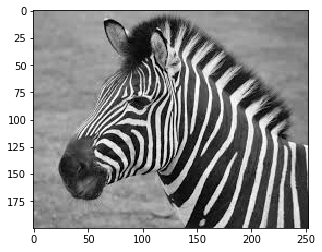

In [217]:
# lets start with our zebra  image:
img = imread('zebra.jpeg',as_grey = True)

plt.imshow(img, cmap='gray',interpolation='nearest')
plt.show()

## step 1: smooth with a Gaussian filter:

(use your `filter2D` function from exercise 2)


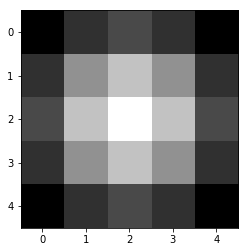

In [218]:
def gaussian(n,sigma):
    # generates a Gaussian kernel of size (2n+1)*(2n+1)
    x = np.arange(-n,n+1)
    y = np.arange(-n,n+1)
    xx, yy = np.meshgrid(x,y)
    z = np.exp(-(xx**2+yy**2)/(2*sigma**2))
    z = z/z.sum()
    return z
               
gaussian_kernel = gaussian(2, 1.5)            
plt.imshow(gaussian_kernel, cmap='gray')
plt.show()


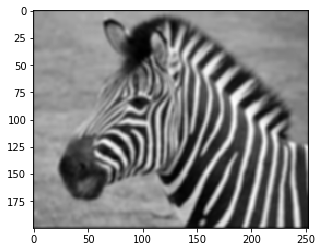

In [219]:


def filter2D(img_in, kernel):
    # check kernel dimensions
    ker_h, ker_w = kernel.shape
    if ker_h != ker_w:
        raise ValueError('expected square-size kernel')
    if ker_h % 2 == 0:
        raise ValueError('expected odd-size kernel')
    n = (ker_h - 1) // 2

    img_h, img_w = img_in.shape

    img_in_p = np.zeros((img_h + 2 * n, img_w + 2 * n))

    # add paddings
    for i in range(img_h):
        for j in range(img_w):
            img_in_p[i + n][j + n] = img_in[i][j]

    img_out = np.zeros((img_h, img_w))

    for i in range(img_h):
        for j in range(img_w):
            img_out[i][j] = (img_in_p[i:i + 2 * n + 1, j:j + 2 * n + 1] * kernel).sum()
    return img_out


Z = filter2D(img, gaussian_kernel)
plt.imshow(Z, cmap='gray')
plt.show()


## step 2: calculate gradients 

a) use 3x3 Sobel operators (Sx and Sy) to calculate Gx and Gy. 

b) from Gx and Gy generate the magnitudes map (G) and the directions map (theta)



[[-0.125  0.     0.125]
 [-0.25   0.     0.25 ]
 [-0.125  0.     0.125]]
[[-0.125 -0.25  -0.125]
 [ 0.     0.     0.   ]
 [ 0.125  0.25   0.125]]


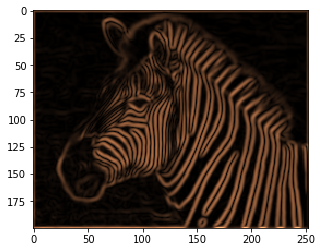

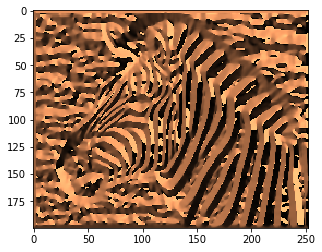

In [220]:

sobel_x =   1/8 * np.array([[-1,0,1], [-2,0,2],[-1,0,1]])
sobel_y = np.transpose(sobel_x)

print(sobel_x)
print(sobel_y)

gxx = filter2D(Z,sobel_x)
gyy = filter2D(Z,sobel_y)
G = np.sqrt(gxx**2 + gyy**2)
theta = np.arctan2(gyy,gxx) + np.pi
plt.imshow(G,cmap=plt.cm.copper)
plt.show()
plt.imshow(theta,cmap=plt.cm.copper)
plt.show()
# plot the results (Gx,Gy,G and theta)



## nearest-neighbors

before the next step, lets prepare 8 new matrices: each matrix will hold the gradient values of one of the 8 possible neighbors. 

for exmaple: G_N[y,x] holds the gradient of the 'North'-neighbor of pixel [y,x]:

`> G_N[y,x] = G[y-1,x] `

likewise for 'West' direction: 

`> G_W[y,x] = G[y,x-1] `




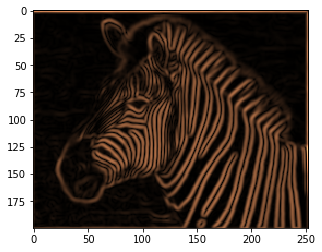

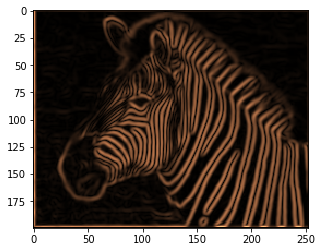

In [221]:
G_N = np.zeros_like(G)  # the North neighbor
G_N[1:,:] = G[:-1,:]
G_S = np.zeros_like(G)
G_S[:-1,:] = G[1:,:]
G_E = np.zeros_like(G)
G_E[:,:-1] = G[:,1:] 
G_W = np.zeros_like(G)
G_W[:,1:] = G[:,:-1]
G_NE = np.zeros_like(G)
G_NE[1:,:-1] = G[:-1,1:]
G_NW = np.zeros_like(G)
G_NW[1:,1:] = G[:-1,:-1]
G_SE = np.zeros_like(G)
G_SE[:-1,:-1] = G[1:,1:]
G_SW = np.zeros_like(G)
G_SW[:-1,1:] = G[1:,:-1]

plt.imshow(G_NE,cmap='copper')
plt.show()
plt.imshow(G_SW,cmap='copper')
plt.show()
# continue with neighbors on the other 7 directions (S, E, W, NE, NW, SE and SW)

# your code here..

# plot G_NE and G_SW for example, to verify it looks ok..

## step 3: Non-Maxima Suppression (NMS)

first, we will quantize the gradient directions (theta) into 4 orientations
> W-E, NW-SE, N-S, NE-SW

generate a matrix 'T' that assign for each pixel T[y,x] one of the 4 orientations {1,2,3,4}:

$$ T[y,x] \in \{1,2,3,4\} $$

where,

1. W-E
2. NW-SE
3. N-S
4. NW-SW


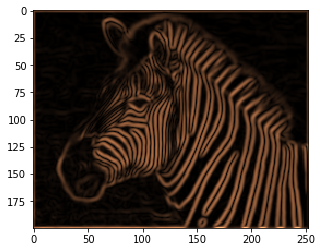

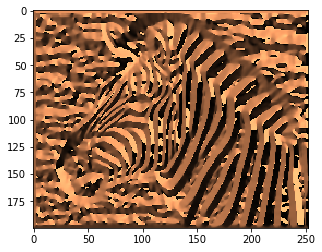

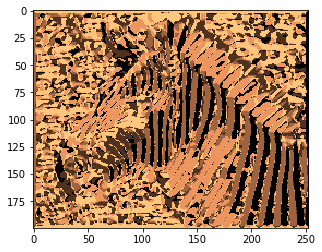

In [222]:
theta2 = np.arctan2(gyy,gxx)
ang = (1+theta2 / np.pi) * 8
T = np.zeros_like(ang)
T[(ang>5) * (ang<7) + (ang>13)*(ang<15)] = 1
T[(ang>7) * (ang<9) + (ang>15)*(ang<1)] = 2
T[(ang>9) * (ang<11) + (ang>1)*(ang<3)] = 3
T[(ang>11) * (ang<13) + (ang>3)*(ang<5)] = 4

plt.imshow(G,cmap='copper')
plt.show()
plt.imshow(theta2,cmap='copper')
plt.show()
plt.imshow(T,cmap='copper')
plt.show()

# plot side-by-side: G, theta and T

### next, we perform 'non-maxima suppression': 

`> G[y,x] -> G_nms[y,x]`

for each pixel check its 2-neighbors along its gradient direction.

if its value is maximal among them - keep it (copy it to G_nms)
otherwise - suppress it (put zero value in its position in G_nms)


hint: no need for any loops here, just some logical operations..



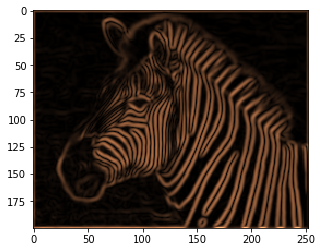

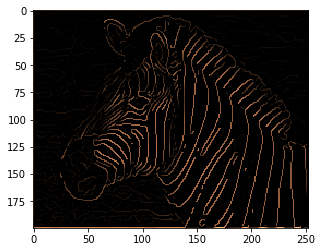

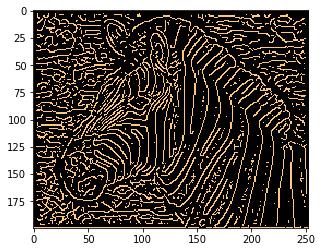

In [223]:
G_nms = (G * (T==1) * (G > G_NE) * (G > G_SW) +
G * (T==2) * (G > G_W) * (G > G_E) +
G * (T==3) * (G > G_NW) * (G > G_SE) +
G * (T==4) * (G > G_N) * (G > G_S))

plt.imshow(G,cmap='copper')
plt.show()
plt.imshow(G_nms,cmap='copper')
plt.show()
plt.imshow(G_nms > 0,cmap='copper')
plt.show()

# plot side by side: G, G_nms and G_nms>0

### step 4: double thresholding 

define two threshold values based on the gradient values in G_nms.

generate a boolean matrix 'strong', for pixels where:
> G_nms[i,j] > th_high

generate a boolean matrix 'weak', for pixels where:
> th_low < G_nms[i,j] < th_high

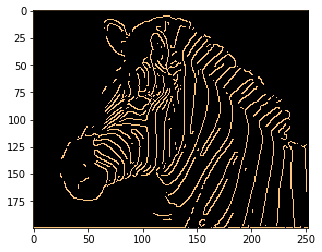

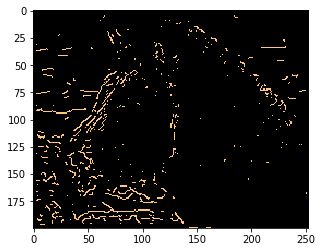

In [224]:

# define two threshold values based on the gradient values in G_nms, 
th_low, th_high = 0.015, 0.05 
strong = G_nms > th_high
weak = (G_nms >= th_low) * (G_nms <= th_high)


plt.imshow(strong,cmap = 'copper')
plt.show()
plt.imshow(weak,cmap = 'copper')
plt.show()

### finally, generate the (binary) Canny matrix Z_canny:

step A: strong pixels are copied to Z_canny

step B (BONUS): weak pixels converts to strong pixels - if they are connected to a strong pixel
this is an iterative process - until all weak pixels are either converted to strong pixels or suppressed.

- plot the result





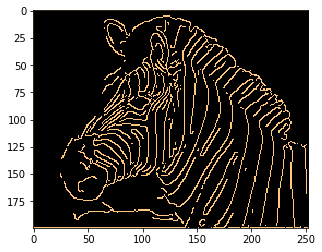

In [225]:
Z_canny = strong
Z_canny_after = np.array(Z_canny)
to_strong = np.zeros_like(Z_canny)
for i in range(1,len(weak)-1):
    for j in range(1,len(weak[0])-1):
        if weak[i,j] > 0 and Z_canny[i,j] == 0:
            for r in range(-1,2):
                for c in range(-1,2):
                        to_strong[i,j] = (to_strong[i,j] + Z_canny[i+r,j+c]) > 0
Z_canny_after = np.array(Z_canny_after + to_strong)
while(not np.array_equal(Z_canny,Z_canny_after)):
    Z_canny = np.array(Z_canny_after)
    to_strong = to_strong * 0
    for i in range(1,len(weak)-1):
        for j in range(1,len(weak[0])-1):
            if weak[i,j] ==1 and Z_canny[i,j] == 0:
                for r in range(-1,2):
                    for c in range(-1,2):
                            to_strong[i,j] = (to_strong[i,j] + Z_canny[i+r,j+c]) > 0
    Z_canny_after = np.array(Z_canny_after + to_strong)
    
    
    
plt.imshow(Z_canny,cmap='copper')
plt.show()
                    


### X-ray image

load and display the x-ray image.

run the compelete Canny edge algorithm, and play with the free parameters (Gaussian, th_low and th_high) until you find a satisfactory result.



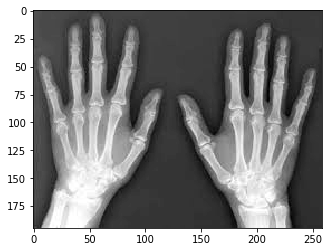

In [226]:
img = imread('xray.jpeg',as_grey = True)

plt.imshow(img, cmap='gray',interpolation='nearest')
plt.show()


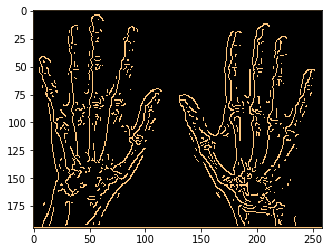

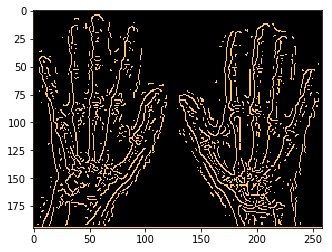

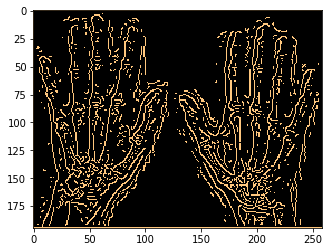

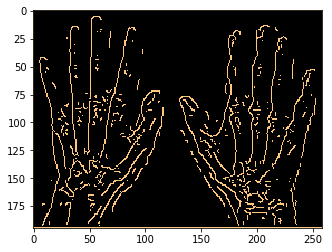

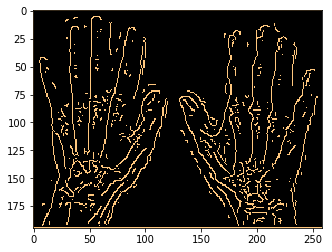

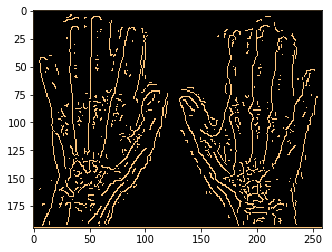

In [227]:
def canny_img(img,gaussian_kernal,th_low,th_high):
    Z = filter2D(img, gaussian_kernal)
    sobel_x =   1/8 * np.array([[-1,0,1], [-2,0,2],[-1,0,1]])
    sobel_y = np.transpose(sobel_x)


    gxx = filter2D(Z,sobel_x)
    gyy = filter2D(Z,sobel_y)
    G = np.sqrt(gxx**2 + gyy**2)
    
    G_N = np.zeros_like(G)  # the North neighbor
    G_N[1:,:] = G[:-1,:]
    G_S = np.zeros_like(G)
    G_S[:-1,:] = G[1:,:]
    G_E = np.zeros_like(G)
    G_E[:,:-1] = G[:,1:] 
    G_W = np.zeros_like(G)
    G_W[:,1:] = G[:,:-1]
    G_NE = np.zeros_like(G)
    G_NE[1:,:-1] = G[:-1,1:]
    G_NW = np.zeros_like(G)
    G_NW[1:,1:] = G[:-1,:-1]
    G_SE = np.zeros_like(G)
    G_SE[:-1,:-1] = G[1:,1:]
    G_SW = np.zeros_like(G)
    G_SW[:-1,1:] = G[1:,:-1]
    
    theta2 = np.arctan2(gyy,gxx)
    ang = (1+theta2 / np.pi) * 8
    T = np.zeros_like(ang)
    T[(ang>5) * (ang<7) + (ang>13)*(ang<15)] = 1
    T[(ang>7) * (ang<9) + (ang>15)*(ang<1)] = 2
    T[(ang>9) * (ang<11) + (ang>1)*(ang<3)] = 3
    T[(ang>11) * (ang<13) + (ang>3)*(ang<5)] = 4
    
    G_nms = (G * (T==1) * (G > G_NE) * (G > G_SW) +
    G * (T==2) * (G > G_W) * (G > G_E) +
    G * (T==3) * (G > G_NW) * (G > G_SE) +
    G * (T==4) * (G > G_N) * (G > G_S))
    
    strong = G_nms > th_high
    weak = (G_nms >= th_low) * (G_nms <= th_high)
    
    Z_canny = strong
    Z_canny_after = np.array(Z_canny)
    to_strong = np.zeros_like(Z_canny)
    for i in range(1,len(weak)-1):
        for j in range(1,len(weak[0])-1):
            if weak[i,j] > 0 and Z_canny[i,j] == 0:
                for r in range(-1,2):
                    for c in range(-1,2):
                            to_strong[i,j] = (to_strong[i,j] + Z_canny[i+r,j+c]) > 0
    Z_canny_after = np.array(Z_canny_after + to_strong)
    while(not np.array_equal(Z_canny,Z_canny_after)):
        Z_canny = np.array(Z_canny_after)
        to_strong = to_strong * 0
        for i in range(1,len(weak)-1):
            for j in range(1,len(weak[0])-1):
                if weak[i,j] ==1 and Z_canny[i,j] == 0:
                    for r in range(-1,2):
                        for c in range(-1,2):
                                to_strong[i,j] = (to_strong[i,j] + Z_canny[i+r,j+c]) > 0
    Z_canny_after = np.array(Z_canny_after + to_strong)
    

    return Z_canny


for i in range(1,4):
    img_1 = canny_img(img,gaussian(1,2),0.001 / i,0.02 / i)
    plt.imshow(img_1,cmap='copper')
    plt.show()

for i in range(2,5):
    img_2 = canny_img(img,gaussian(2,3),0.001 / i,0.02 / i)
    plt.imshow(img_2,cmap='copper')
    plt.show()
    

# Good luck !